# DEA Waterbodies threshold sensitivity analysis <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with the `NCI` environment only.
* **Products used:** 
None
* **Special requirements:** 
    * NetCDF files with WOfS outputs that will be used to define the persistent water body polygons
        * Variable name: `TileFolder`
        * This folder can be either a custom extraction of datacube-stats (as was done here), or you can choose to use the WOfS summary tiles for all of Australia.
    * Urban high rise polygon dataset
        * Variable name: `UrbanMaskFile`. 
        * WOfS has a known limitation, where deep shadows thrown by tall CBD buildings are misclassified as water. This results in 'waterbodies' around these misclassified shadows in capital cities.
* **Prerequisites:** This notebook explores the sensitivity of WOfS analysis time range and wetness thresholds during the DEA Waterbodies analysis ([see this notebook for the implementation of these thresholds](../TurnWaterObservationsIntoWaterbodyPolygons.ipynb)). It has been designed with that very specific purpose in mind, and is not intended as a general analysis notebook. 

## Background
This notebook is an ammended copy of an old version of [`TurnWaterObservationsIntoWaterbodyPolygons.ipynb`](../TurnWaterObservationsIntoWaterbodyPolygons.ipynb). Note that the functions and workflow represent an earlier version of the final workflow used to produce DEA Waterbodies. 

## Description
This notebook tests the impact of using different time range and wetness thresholds on the number, size, and spatial distribution of identified waterbodies. This notebook assists in the selection of appropriate thresholds by exploring the impact of different values on the overall results. 

There are two parameters that are explored here:
- Time range
- Wetness threshold

**Time range** 
The time range refers to the length of time over which the water classified summary statistics are calculated. The water classifier used here is the [Water Observations from Space (WOfS)](https://www.sciencedirect.com/science/article/pii/S0034425715301929) decision tree algorithm. 

The summary statistics were generated using the [datacube-stats](https://github.com/opendatacube/datacube-stats) package, which is a tool for generating large-scale temporal statistics on data within Digital Earth Australia. This package was used to calculate frequency counts and statistics for: 

Time ranges tested:
- Jan 1990 to Dec 2018
- Jan 1995 to Dec 2018
- Jan 2000 to Dec 2018
- Jan 2005 to Dec 2018
- Jan 2010 to Dec 2018
- Jan 2015 to Dec 2018

These summary statistics were pre-calculated, and then imported using the `CustomData` parameter below.

**Wetness threshold**
The second important parameter using in the generation of the waterbody polygons is the wetness threshold. The wetness threshold indicates how frequently a pixel needed to be observed as wet in order to be included. A wetness threshold of 0.1 means that at least 10% of the total, valid observations needed to be classified as 'wet'. This threshold needs to be sensitive enough to capture the locations of persistent waterbodies, but not so sensitive as to pick up false positives like flood irrigation, flood events or soggy areas in the landscape. 

Wetness thresholds tested:
- 0.2
- 0.1
- 0.05
- 0.02
- 0.01 - this test was not completed for 2015-2018 as the number of polygons was too high. This threshold is far too sensitive.

The suitability of each time range/wetness threshold was tested in three separate locations across NSW, representing three different landcover types; desert floodplain, irrigated cropping, combination of natural water and irrigated cropping.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

import rasterio.features
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math
import seaborn
import re

### Set up the functions for this script

In [4]:
def Generate_list_of_albers_tiles(TileFolder='TileFolder', CustomData=True):
    '''
    Generate a list of Albers tiles to loop through for the water body analysis. This 
    function assumes that the list of tiles will be generated from a custom 
    datacube-stats run, and the file names will have the format
    
    */wofs_summary_8_-37_{date}.nc
    
    The tile number is expected in the 2nd and 3rd last positions when the string has been
    broken using `_`. If this is not the case, then this code will not work, and will throw an error. 
    
    Parameters
    ----------
    
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    CustomData : boolean
        This is passed in from elsewhere in the notebook. If this is not entered, the default parameter is True.
    
    Returns
    -------
    CustomRegionAlbersTiles: list
        List of Albers tiles across the analysis region. 
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    
    '''
    if os.path.exists(TileFolder) == False:
        print(
            '** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        return

    # Grab a list of all of the netCDF files in the tile folder
    TileFiles = glob.glob(f'{TileFolder}*.nc')

    CustomRegionAlbersTiles = set()
    for filePath in TileFiles:
        AlbersTiles = re.split('[_\.]', filePath)
        if CustomData:
            # Test that the albers tile numbers are actually where we expect them to be in the file name
            try:
                int(AlbersTiles[-4])
                int(AlbersTiles[-3])
            except ValueError:
                print(
                    '** ERROR ** \n'
                    'The netCDF files are expected to have the file format "*/wofs_summary_8_-37_{date}.nc",\n'
                    'with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_`. \n'
                    'Please fix the file names, or alter the `Generate_list_of_albers_tiles` function.'
                )
                return

            # Now that we're happy that the file is reading the correct Albers tiles
            ThisTile = f'{AlbersTiles[-3]}_{AlbersTiles[-2]}'
        else:
            # Test that the albers tile numbers are actually where we expect them to be in the file name
            try:
                int(AlbersTiles[-3])
                int(AlbersTiles[-2])
            except ValueError:
                print(
                    '** ERROR ** \n'
                    'The netCDF files are expected to have the file format "*/wofs_filtered_summary_8_-37.nc",\n'
                    'with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_` and `.`. \n'
                    'Please fix the file names, or alter the `Generate_list_of_albers_tiles` function.'
                )
                return

            # Now that we're happy that the file is reading the correct Albers tiles
            ThisTile = f'{AlbersTiles[-3]}_{AlbersTiles[-2]}'
        CustomRegionAlbersTiles.add(ThisTile)
    CustomRegionAlbersTiles = list(CustomRegionAlbersTiles)
    return CustomRegionAlbersTiles


def Generate_list_of_tile_datasets(ListofAlbersTiles,
                                   Year,
                                   TileFolder='TileFolder',
                                   CustomData=True):
    '''
    Generate a list of Albers tiles datasets to loop through for the water body analysis. Here, the 
    ListofAlbersTiles is used to generate a list of NetCDF files where the Albers coordinates have 
    been substituted into the naming file format.
    
    Parameters
    ----------
    
    CustomRegionAlbersTiles: list
        List of albers tiles to loop through
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    Year: int
        Year for the analysis. This will correspond to the netCDF files for analysis.
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    CustomData : boolean
        This is passed from elsewhere in the notebook. If this parameter is not entered, the default value
        is True.
    
    Returns
    -------
    Alltilespaths: list
        List of file paths to files to be analysed.
    
    '''

    if os.path.exists(TileFolder) == False:
        print(
            '** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        raise

    Alltilespaths = []

    if CustomData:
        for tile in ListofAlbersTiles:
            Tiles = glob.glob(f'{TileFolder}*_{tile}_{Year}0101.nc')
            Alltilespaths.append(
                Tiles[0])  # Assumes only one file will be returned
    else:
        for tile in ListofAlbersTiles:
            # Use glob to check that the file actually exists in the format we expect
            Tiles = glob.glob(f'{TileFolder}wofs_filtered_summary_{tile}.nc')
            # Check that assumption by seeing if the returned list is empty
            if not Tiles:
                Tiles = glob.glob(f'{TileFolder}WOFS_3577_{tile}_summary.nc')
            # Check that we actually have something now
            if not Tiles:
                print(
                    '** ERROR ** \n'
                    'An assumption in the file naming conventions has gone wrong somewhere.\n'
                    'We assume two file naming formats here: {TileFolder}wofs_filtered_summary_{tile}.nc, \n'
                    'and {TileFolder}WOFS_3577_{tile}_summary.nc. The files you have directed to don\'t meet \n'
                    'either assumption. Please fix the file names, or alter the `Generate_list_of_albers_tiles` function.'
                )
            Alltilespaths.append(
                Tiles[0])  # Assumes only one file will be returned

    return Alltilespaths


def Filter_shapefile_by_intersection(gpdData,
                                     gpdFilter,
                                     filtertype='intersects',
                                     invertMask=True,
                                     returnInverse=False):
    '''
    Filter out polygons that intersect with another polygon shapefile. 
    
    Parameters
    ----------
    
    gpdData: geopandas dataframe
        Polygon data that you wish to filter
    gpdFilter: geopandas dataframe
        Dataset you are using as a filter
    
    Optional
    --------
    filtertype: default = 'intersects'
        Options = ['intersects', 'contains', 'within']
    invertMask: boolean
        Default = 'True'. This determines whether you want areas that DO ( = 'False') or DON'T ( = 'True')
        intersect with the filter shapefile.
    returnInnverse: boolean
        Default = 'False'. If true, then return both parts of the intersection - those that intersect AND 
        those that don't as two dataframes.
    
    Returns
    -------
    gpdDataFiltered: geopandas dataframe
        Filtered polygon set, with polygons that intersect with gpdFilter removed.
    IntersectIndex: list of indices of gpdData that intersect with gpdFilter
    
    Optional
    --------
    if 'returnInverse = True'
    gpdDataFiltered, gpdDataInverse: two geopandas dataframes
        Filtered polygon set, with polygons that DON'T intersect with gpdFilter removed.
    '''

    # Check that the coordinate reference systems of both dataframes are the same

    #assert gpdData.crs == gpdFilter.crs, 'Make sure the the coordinate reference systems of the two provided dataframes are the same'

    Intersections = gp.sjoin(gpdFilter, gpdData, how="inner", op=filtertype)

    # Find the index of all the polygons that intersect with the filter
    IntersectIndex = sorted(set(Intersections['index_right']))

    # Grab only the polygons NOT in the IntersectIndex
    # i.e. that don't intersect with a river
    if invertMask:
        gpdDataFiltered = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
    else:
        gpdDataFiltered = gpdData.loc[gpdData.index.isin(IntersectIndex)]

    if returnInverse:
        # We need to use the indices from IntersectIndex to find the inverse dataset, so we
        # will just swap the '~'.

        if invertMask:
            gpdDataInverse = gpdData.loc[gpdData.index.isin(IntersectIndex)]
        else:
            gpdDataInverse = gpdData.loc[~gpdData.index.isin(IntersectIndex)]

        return gpdDataFiltered, IntersectIndex, gpdDataInverse
    else:

        return gpdDataFiltered, IntersectIndex

### Analysis parameters

See [this notebook](../TurnWaterObservationsIntoWaterbodyPolygons.ipynb) for an extensive discussion on each of these parameters.

* `MinimumValidObs`: How many valid observations must there be for a pixel for it to be included in the analysis
* `MinSize`: What is the minimum waterbody size in m2
* `MaxSize`: What is the maximum waterbody size in m2
* `UrbanMaskFile`: file directory to a shapefile containing an urban mask to filter out incorrect polygons caused by deep urban shadows.

In [5]:
MinimumValidObs = 128

In [6]:
MinSize = 3120  # 5 pixels
MaxSize = math.inf  # No upper limit

In [9]:
UrbanMaskFile = '/g/data/r78/cek156/ShapeFiles/ABS_1270055001_sa3_2016_aust_shape/HighRiseCBD_ABS_sa3.shp'

CBDs = gp.read_file(UrbanMaskFile)
CBDs = CBDs.to_crs({'init': 'epsg:3577'})

## Experimental variables
### Time range

Precomputer WOfS summary statistics were calculated using the [datacube-stats](https://github.com/opendatacube/datacube-stats) package. 
These different time range statistic calculations were manually cycled through using the `CustomData` parameter here.
* `CustomData`: if `True`, you will need to specify the location of the data you would like to use for this analysis, setting `TileFolder` below. If `False`, the code will automatically look at the published WOfS all time summaries.

In [8]:
CustomData = False
AutoGenerateTileList = False

if CustomData:
    TileFolder = '/g/data/r78/cek156/datacube_stats/WOFSDamsAllTimeNSWMDB/'
else:
    TileFolder = '/g/data/fk4/datacube/002/WOfS/WOfS_Stats_25_2_1/netcdf/'

# We only want to generate the tile list if we are not doing all of Australia.
if not AllOfAustraliaAllTime:
    if AutoGenerateTileList:
        ListofAlbersTiles = Generate_list_of_albers_tiles(
            TileFolder, CustomData)
    else:
        ListofAlbersTiles = ['7_-34', '10_-40', '16_-34']

### Wetness threshold
This variable is manually varied to test the sensitivity of this parameter on the overall results:
- 0.2
- 0.1
- 0.05
- 0.02
- 0.01

In [23]:
AtLeastThisWet = 0.2

### List of experiments

The time range and wetness thresholds were both varied, producing a total of 29 experiments.The final experiment of `2015-18` and `0.01` produced *way too many* polygons and so took a long time to complete. After a day I just stopped it running.

|     Time Range\Wetness Threshold       |0.02  |0.1 |0.05 |0.02 |0.01 |
|-----------| ------------------|----------|----------|----------|----------|
|Jan 1990 to Dec 2018 | &#9745; | &#9745;  |  &#9745; | &#9745;  |  &#9745; |
|Jan 1995 to Dec 2018  | &#9745; | &#9745;  |  &#9745; | &#9745;  |  &#9745; |
|Jan 2000 to Dec 2018  | &#9745; | &#9745;  |  &#9745; | &#9745;  |  &#9745; |
|Jan 2005 to Dec 2018 | &#9745; | &#9745;  |  &#9745; | &#9745;  |  &#9745; |
|Jan 2010 to Dec 2018  | &#9745; | &#9745;  |  &#9745; | &#9745;  |  &#9745; |
|Jan 2015 to Dec 2018  | &#9745; | &#9745;  |  &#9745; | &#9745;  |  &#9744; |


## Loop through each tile and polygonise the WOfS statistics data

Note that this is an older version of the code that was used to produce the final DEA Waterbodies polygons. See [`TurnWaterObservationsIntoWaterbodyPolygons.ipynb`](../TurnWaterObservationsIntoWaterbodyPolygons.ipynb) for the most recent workflow.

### Analysis parameters
* `year`: here is how you manually loop through the different time ranges. Set this to be the first year of the time range period you are analysing.

In [24]:
# This code does the analysis a year at a time. If there is a single year only, set the year range to be
# `range(year, year + 1)`

year = '1987'

### Set up some file names for the inputs and outputs

# The name and filepath of the intermediate output polygon set
WaterBodiesShp = f'/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/DEAWaterbodiesThresholdAnalysis/WaterBodies{year}_{AtLeastThisWet}.shp'

### Get the list of netcdf file names to loop through
if AllOfAustraliaAllTime:
    # Grab everything from the published WOfS all time summaries
    Alltiles = glob.glob(f'{TileFolder}*.nc')
else:
    Alltiles = Generate_list_of_tile_datasets(ListofAlbersTiles, year,
                                              TileFolder, CustomData)

for WOFSfile in Alltiles:
    # Read in the data
    # Note that the netCDF files we are using here contain a variable called 'frequency',
    # which is what we are using to define our water polygons.
    # If you use a different netCDF input source, you may need to change this variable name here
    WOFSnetCDFData = xr.open_rasterio(f'NETCDF:{WOFSfile}:frequency')
    # Remove the superfluous time dimension
    WOFSnetCDFData = WOFSnetCDFData.squeeze()

    # Open the clear count variable to generate the minimum observation mask
    WOFSvalidcount = xr.open_rasterio(f'NETCDF:{WOFSfile}:count_clear')
    WOFSvalidcount = WOFSvalidcount.squeeze()

    # Filter our WOfS classified data layer to remove noise
    # Remove any pixels not abserved at least MinimumValidObs times
    WOFSValidFiltered = WOFSvalidcount >= MinimumValidObs

    # Remove any pixels that are wet < AtLeastThisWet% of the time
    WOFSfiltered = WOFSnetCDFData > AtLeastThisWet

    # Now find pixels that meet both the MinimumValidObs and AtLeastThisWet criteria
    # Change all zeros to NaN to create a nan/1 mask layer
    # Pixels == 1 now represent our water bodies
    WOFSfiltered = WOFSfiltered.where((WOFSfiltered != 0) &
                                      (WOFSValidFiltered != 0))

    # Convert the raster to polygons
    # We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
    WOFSpolygons = rasterio.features.shapes(
        WOFSfiltered.data.astype('float32'),
        mask=WOFSfiltered.data.astype('float32') == 1,
        transform=WOFSnetCDFData.transform)
    # The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
    # not the value of each polygon (which here is just 1 for everything)
    WOFSbreaktuple = (a for a, b in WOFSpolygons)

    # Put our polygons into a geopandas geodataframe
    PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))

    # Grab the geometries and convert into a shapely geometry
    # so we can quickly calcuate the area of each polygon
    PolygonGP['geometry'] = None
    for ix, poly in PolygonGP.iterrows():
        poly['geometry'] = shape(poly)

    # Set the geometry of the dataframe to be the shapely geometry we just created
    PolygonGP = PolygonGP.set_geometry('geometry')
    # We need to add the crs back onto the dataframe
    PolygonGP.crs = {'init': 'epsg:3577'}

    # Combine any overlapping polygons
    MergedPolygonsGeoms = unary_union(PolygonGP['geometry'])

    # Turn the combined multipolygon back into a geodataframe
    MergedPolygonsGPD = gp.GeoDataFrame([poly for poly in MergedPolygonsGeoms])
    # Rename the geometry column
    MergedPolygonsGPD.columns = ['geometry']
    # We need to add the crs back onto the dataframe
    MergedPolygonsGPD.crs = {'init': 'epsg:3577'}

    # Calculate the area of each polygon again now that overlapping polygons
    # have been merged
    MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area

    # Filter out any polygons smaller than MinSize, and greater than MaxSize
    WaterBodiesBig = MergedPolygonsGPD.loc[(
        (MergedPolygonsGPD['area'] > MinSize) &
        (MergedPolygonsGPD['area'] <= MaxSize))]

    # WOfS has a known bug where deep shadows from high-rise CBD buildings are misclassified
    # as water. We will use the ABS sa3 dataset to filter out Brisbane, Gold Coast, Sydney,
    # Melbourne, Adelaide and Perth CBDs.
    NotCities = Filter_shapefile_by_intersection(WaterBodiesBig, CBDs)

    # Save the polygons to a shapefile
    schema = {'geometry': 'Polygon', 'properties': {'area': 'str'}}

    if os.path.isfile(WaterBodiesShp):
        with fiona.open(WaterBodiesShp,
                        "a",
                        crs=from_epsg(3577),
                        driver='ESRI Shapefile',
                        schema=schema) as output:
            for ix, poly in NotCities[0].iterrows():
                output.write(({
                    'properties': {
                        'area': poly['area']
                    },
                    'geometry': mapping(shape(poly['geometry']))
                }))
    else:
        with fiona.open(WaterBodiesShp,
                        "w",
                        crs=from_epsg(3577),
                        driver='ESRI Shapefile',
                        schema=schema) as output:
            for ix, poly in NotCities[0].iterrows():
                output.write(({
                    'properties': {
                        'area': poly['area']
                    },
                    'geometry': mapping(shape(poly['geometry']))
                }))

## Compare the threshold results

In [13]:
# Create a list of all of the sensitivity test shapefiles
AllSensitivityResults = glob.glob(
    f'/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/DEAWaterbodiesThresholdAnalysis/WaterBodies*.shp'
)

### Exploring the effect of time range on results

Here we use the total area inside all identified polygons as a means to assess the relative impact of time range and threshold on the results. 

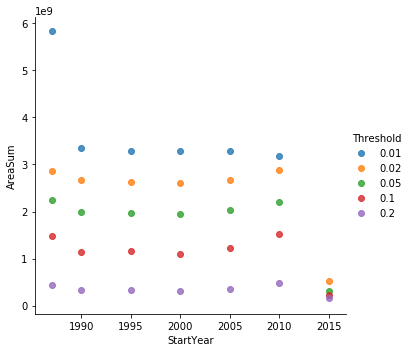

In [19]:
AreaData = []

for File in AllSensitivityResults:
    PolygonShapes = gp.read_file(File)
    AllPolygonArea = PolygonShapes.area.sum()
    # Break up the file name to get the start year, and threshold
    GDataBit, ExtraBit, ThresholdBit = File.split('_')
    StartYear = ExtraBit[-4:]
    Threshold = ThresholdBit[:-4]
    AreaData.append([AllPolygonArea, StartYear, Threshold])

AreaDataFrame = pd.DataFrame(AreaData, columns=['AreaSum', 'StartYear', 'Threshold'])
AreaDataFrame['StartYear'] = pd.to_numeric(AreaDataFrame['StartYear'])

seaborn.lmplot(x='StartYear', y='AreaSum', data = AreaDataFrame, fit_reg = False, hue = 'Threshold')

**From the figure above we can conclude that the number of years over which the results are integrated doesn't have a large affect on the overall results, with the exception of the 2015-2018 analysis.** 

We can see that the sensitivity of the results from the 2015-2018 analysis is far too low, and many of the polygon pixels picked up in the other analyses are missed over this short integration period. 

The combination of the 0.01 wetness threshold and the all time analysis (1987-2018) sees a large spike in the overall area of identified waterbodies. This result appears to be an outlier and suggests that the 0.01 threshold is too sensitive over this long time period. 

The remaining experiments all produce very similar results, suggesting that **the time period over which the analysis is performed does not have a strong overall impact on the waterbodies generated.**

We therefore choose to use all available observations, to limit the use of custom analysis periods, and to be consistent with the [WOfS all time summary product](https://cmi.ga.gov.au/wo-filt-stats_25_2.1.5). 

## Exploring the effect of different wetness thresholds on the overall results

Here we explore the effect of difference wetness thresholds on the total area inside all identified polygons for each sensitivity test combination.

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


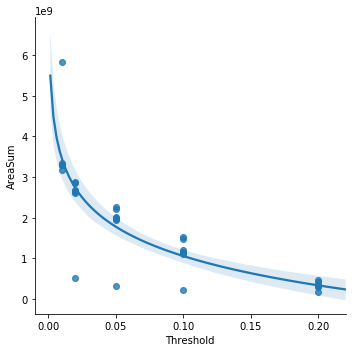

In [20]:
AreaDataFrame['Threshold'] = pd.to_numeric(AreaDataFrame['Threshold'])
seaborn.lmplot(x='Threshold', y='AreaSum', data = AreaDataFrame, logx = True)

**Overall, we can see that the total area of identified polygons increases as the threshold applied reduces.**

The outliers seen on this plot represent the data for the 2015-2018 period, where the total polygon area is underestimated.

It is unclear from this plot whether the increase in total polygon area is related to the identification of more polygons, or simply increases in the relative size of individual polygons. 

## Impact of wetness threshold on polygon number and size

Here we explore both the number and size of polygons identified using each of the tested thresholds. We perform this analysis only for the 1987-2018 results, as these have been identified as the preferred time range in the analysis above. 

Text(0, 0.5, 'Histogram count')

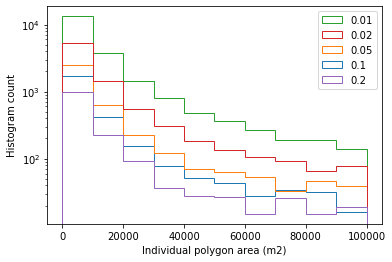

In [21]:
fig, ax = plt.subplots()
for File in AllSensitivityResults:
    GDataBit, ExtraBit, ThresholdBit = File.split('_')
    StartYear = ExtraBit[-4:]
    Threshold = ThresholdBit[:-4]
    
    # Only perform the analysis on results for 2000-2018
    if StartYear == '1987':
        PolygonShapes = gp.read_file(File)
        PolygonShapes['area'] = pd.to_numeric(PolygonShapes['area'])

        plt.hist(PolygonShapes['area'], bins = list(range(0, 110000, 10000)), 
                 label=Threshold, histtype = 'step')
    else:
        continue

handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*[ (handles[i], labels[i]) 
                        for i in sorted(range(len(handles)), 
                                        key=lambda k: list(map(float,labels))[k])] )
        
plt.legend(handles, labels)
plt.yscale('log')
plt.xlabel('Individual polygon area (m2)')
plt.ylabel('Histogram count')

From the above plot, we can draw the following conclusions:
* Generally, a lower threshold means more *total* waterbody polygons are identified.
* Generally, a lower threshold means more *larger sized* waterbody polygons are identified.
* It's not clear from our analysis of the threshold results so far which wetness threshold is most suitable. 

## Are more (and larger) polygons better?

An assessment as to the most appropriate final threshold to use will need to be somewhat subjective. While we can quantify the different affects caused by varying the time period and wetness threshold, a judgement call as to an acceptable signal:noise ratio will need to be made. 

Here we provide the evidence used to come to the final decision.

![All thresholds](../DocumentationFigures/AllThresholds.JPG "All thresholds shown, with darker blues = higher thresholds, and lighter blues for lower thresholds")

In the above image, all of the wetness thresholds, all run over the same time range, have been plotted together. The darkest blue represents the 0.01 threshold, with the lightest blue being 0.2.

The lowest threshold of 0.01, shown in the darkest blue, returns a much larger number of polygons than the other thresholds, but most of these seem to be noise. There is some clear striping from Landsat 7's scan line corrector failure (lower right corner), as well as a lot of small polygons that do not clearly line up with waterbody features. 

This same conclusion was drawn from examination of the 0.01 wetness threshold in other locations.

**We therefore discount 0.01 (i.e. 1%) as a useful wetness threshold.**

![Remove 0.01](../DocumentationFigures/No0.01.JPG "All thresholds shown, with darker blues = higher thresholds, and lighter blues for lower thresholds")

With the 0.01 threshold removed, it is clear that most of the noisy polygons have also been removed. There still remains a reasonable number of small, noisy pixels that appear to be associated with intermittently wet features (like soggy bits in paddocks), rather than water bodies. 

This was also found at other testing locations.

**We therefore discount 0.02 (i.e. 2%) as an acceptable wetness threshold**

![Remove 0.02](../DocumentationFigures/No0.02.JPG "All thresholds shown, with darker blues = higher thresholds, and lighter blues for lower thresholds")

On the left hand side of the image above (and in other areas not shown), we can see that the threshold of 0.2 misses parts of water bodies (as seen by the smaller polygons sitting inside of the larger ones), resulting in only portions of waterbodies being mapped. It also misses entire waterbodies, which are observed as wet less frequently.

**The sensitivity of the 0.2 (20%) wetness threshold is too conservative, so we therefore discount it as an acceptable wetness threshold.**

Determining the most suitable threshold between the two remaining thresholds (0.1 and 0.05) is difficult. We can see from above, there is little difference between both the total number of water bodies, and the relative size of individual polygons, however spatially, the two threshold can be seen to have quite different results. 

To make the differences between the two thresholds easier to visualise, we have recoloured the polygons:
- 0.1 = purple
- 0.05 = yellow

![Agricultural Comparison](../DocumentationFigures/AgricultureArea.JPG "0.1 Threshold = purple, 0.05 threshold = yellow")

In the area above, (northern NSW), we can see that the lower threshold of 0.05 (shown in yellow) appears to do a better job of characterising waterbodies. The Purple polygons frequently pick up only parts of waterbodies, whereas the yellow polygons pick up the whole waterbody area, as well as some additional smaller waterbodies. 

![Lake Frome Comparison](../DocumentationFigures/LakeFrome.JPG "0.1 Threshold = purple, 0.05 threshold = yellow. The red line denotes the boundary of the test area")

In the example, the lower threshold of 0.05 does a much better job of characterising the extent of Lake Frome in central Australia. Lake Frome is a large floodplain, and so inundates relatively infrequently, making it very sensitive to the threshold used. 

![Flood Irrigation Comparison](../DocumentationFigures/Cotton.JPG "0.1 Threshold = purple, 0.05 threshold = yellow. The red line denotes the boundary of the test area")

In the above region in south central NSW, the issues with the 0.05 threshold become apparent. In this region, flood irrigation is commonly used, resulting in waterbodies being identified within flood irrigated paddocks. The more conservative threshold of 0.1 does a much better job in this region of distinguishing between flood irrigation, and waterbodies. 

## Selecting a wetness threshold

Both the 0.05 and 0.1 thresholds showed both errors of omission and commission, depending on the location in which they were applied. In a location with large areas of flood irrigation, the 0.05 threshold identified a number of paddocks as waterbodies, indicating this threshold is too sensitive in these conditions. In more arid areas, where waterbodies rarely reach their maximum extent, the 0.1 threshold was shown to underrepresent the maximum waterbody extent, picking out only partial polygons within individual waterbodies. 

Given the limitations of both wetness thresholds, a **hybrid threshold was chosen, whereby the locations of waterbodies was identified using the 0.1 threshold, but the spatial extent of these waterbodies was characterized using the 0.05 threshold**. This minimizes errors caused by flood irrigation, which are not readily captured by the 0.1 wetness threshold, but also captures the larger spatial extent of individual waterbodies afforded by the 0.05 threshold. 

While we have chosen a 0.1/0.05 threshold for our purposes, the [DEA Waterbodies code](../TurnWaterObservationsIntoWaterbodyPolygons.ipynb) has been written to allow the user to define their own single, or hybrid threshold, making it customizable to different environmental conditions.

In the example below, showing Lake George near the NSW/ACT border, the 10% threshold shown in blue, captures a smaller spatial footprint of Lake George than the 5% threshold in red. Here we can see that the 5% threshold does a better job of capturing the full spatial footprint of Lake George, i.e. the footprint is closer to how we would manually define the outline of Lake George. This creates a nice compromise between better spatial characterisation of footprints, and the addition of false positives from the lower 5% threshold. 

![Hybrid Threshold effect on Lake George, NSW](../DocumentationFigures/HybridThreshold.JPG "In this example showing Lake George near the NSW/ACT border, the 10% threshold shown in blue, captures a smaller spatial footprint of Lake George than the 5% threshold in red. Here we can see that the 5% threshold does a better job of capturing the full spatial footprint of Lake George")

The area below in south central NSW is an area where flood irrigation is common. The yellow polygons identified below, are those generated from the 5% threshold. The clear presence of 'waterbody' polygons in flood irrigated fields is a good example of the high sensitivity of the 5% threshold, when applied blindly. The hybrid approach (shown in red) shows where the polygons from the 5% threshold have been intentionally selected for inclusion in the final waterbody polygon set. These included polygons intersect with a polygon identified within the 10% threshold, thereby allowing the 10% threshold to identify the location of polygons, but the 5% threshold to characterise their spatial footprint. 

![Threshold sensitivity comparison, south central NSW](../DocumentationFigures/ThresholdCompare.JPG "This example in south central NSW is an area where flood irrigation is common. The yellow polygons are those generated from the 5% threshold. The clear presence of 'waterbody' polygons in flood irrigated fields is a good example of the high sensitivity of the 5% threshold, when applied blindly")

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** N/A

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)